In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import json
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score

In [3]:
from pygraphs.graphs.generator import StochasticBlockModel
from pygraphs.measure import kernels
from pygraphs.cluster import KernelKMeansSklearn, KernelWardSklearn
from pygraphs.scenario import ParallelByGraphs, measures_right_order
from pygraphs.scorer import copeland
from pygraphs.util import load_or_calc_and_save, ddict2dict

In [5]:
kernel_ids = dict([(k.name, i) for i, k in enumerate(kernels)])
kernel_ids

{'pWalk': 0,
 'Walk': 1,
 'For': 2,
 'logFor': 3,
 'Comm': 4,
 'logComm': 5,
 'Heat': 6,
 'logHeat': 7,
 'SCT': 8,
 'SCCT': 9,
 'RSP': 10,
 'FE': 11,
 'PPR': 12,
 'logPPR': 13,
 'ModifPPR': 14,
 'logModifPPR': 15,
 'HeatPPR': 16,
 'logHeatPPR': 17,
 'SP-CT': 18}

In [7]:
with open('result.json') as f:
    overall_result = json.load(f)

In [8]:
np.sqrt(441)

21.0

In [217]:
best_measure, best_ari = np.full((21, 21), np.nan), np.full((21, 21), np.nan)
measure_counter = defaultdict(lambda: 0)
global_ratings = defaultdict(lambda: 0)
measure_ratings = np.full((21, 21, 19), np.nan)
for pin_pout, cell_results in overall_result.items():
    pin, pout = pin_pout.split(', ')
    pin, pout = float(pin), float(pout)
    pin_idx, pout_idx = int(pin / 0.05), int(pout / 0.05)
    
    measure_best_ari = []
    for measure_name, measure_results in cell_results.items():
        if len(measure_results['ari']) > 0:
            best_ari_for_measure = np.nanmax(measure_results['ari'])
            measure_best_ari.append((measure_name, best_ari_for_measure))
    measure_best_ari = sorted(measure_best_ari, key=lambda x: x[1], reverse=True)
    
    for current_name, current_ari in measure_best_ari:
        worse_than = 0
        for measure_name, measure_ari in measure_best_ari:
            if current_ari < measure_ari:
                worse_than += 1
        measure_ratings[pin_idx, pout_idx, kernel_ids[current_name]] = worse_than + 1
        if pin != pout:
            global_ratings[current_name] += 19 - (worse_than + 1)
    
#     if np.sum(np.array([x[1] for x in measure_best_ari]) == 1) < 2:
    best_measure[pin_idx, pout_idx] = kernel_ids[measure_best_ari[0][0]]
    best_ari[pin_idx, pout_idx] = measure_best_ari[0][1]
    measure_counter[measure_best_ari[0][0]] += 1
    
    

In [218]:
p_ins = [f'{x:.2}' for x in np.arange(0, 1.0001, 0.05)]
p_outs = [f'{x:.2}' for x in np.arange(0, 1.0001, 0.05)]

Text(0.5,0,'$p_{out}$')

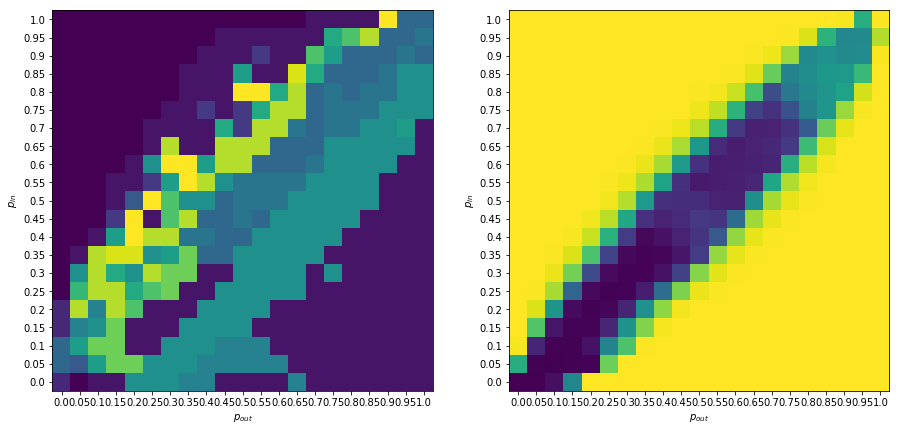

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(best_measure[::-1])
ax[0].set_yticks(range(len(p_ins)))
ax[0].set_xticks(range(len(p_outs)))
ax[0].set_yticklabels(p_ins[::-1])
ax[0].set_xticklabels(p_outs)
ax[0].set_ylabel('$p_{in}$')
ax[0].set_xlabel('$p_{out}$')

ax[1].imshow(best_ari[::-1], vmin=0, vmax=1)
ax[1].set_yticks(range(len(p_ins)))
ax[1].set_xticks(range(len(p_outs)))
ax[1].set_yticklabels(p_ins[::-1])
ax[1].set_xticklabels(p_outs)
ax[1].set_ylabel('$p_{in}$')
ax[1].set_xlabel('$p_{out}$')

In [220]:
d3_category20 = [
    '#1f77b4',
    '#aec7e8',
    '#ff7f0e',
    '#ffbb78',
    '#2ca02c',
    '#98df8a',
    '#d62728',
    '#ff9896',
    '#9467bd',
    '#c5b0d5',
    '#8c564b',
    '#c49c94',
    '#e377c2',
    '#f7b6d2',
    '#7f7f7f',
    '#c7c7c7',
    '#bcbd22',
    '#dbdb8d',
    '#17becf',
    '#9edae5'
]

In [221]:
colors = [tuple(int(d3_category20[a][1:][i:i+2], 16) for i in (0, 2, 4)) for a in range(20)]

In [222]:
best_measure_color = np.zeros((21, 21, 3), dtype=np.uint8)
for i in range(21):
    for j in range(21):
        if not np.isnan(best_measure[i][j]): 
            best_measure_color[i][j] = np.array(colors[int(best_measure[i][j])])

In [223]:
best_ari_1 = best_ari.copy()
best_ari_1[best_ari == 1] = np.nan

In [224]:
a = []
for measure_name in list(kernel_ids.keys()):
    a.append((measure_name, measure_counter[measure_name]))
    print(f'{measure_name}\t{measure_counter[measure_name]}')

pWalk	80
Walk	139
For	3
logFor	6
Comm	0
logComm	2
Heat	31
logHeat	23
SCT	13
SCCT	77
RSP	9
FE	7
PPR	1
logPPR	6
ModifPPR	9
logModifPPR	0
HeatPPR	23
logHeatPPR	3
SP-CT	9


In [225]:
ii = [i for i, x in enumerate(a) if x[1] > 0]

In [226]:
sorted(a, key=lambda x: x[1], reverse=True)

[('Walk', 139),
 ('pWalk', 80),
 ('SCCT', 77),
 ('Heat', 31),
 ('logHeat', 23),
 ('HeatPPR', 23),
 ('SCT', 13),
 ('RSP', 9),
 ('ModifPPR', 9),
 ('SP-CT', 9),
 ('FE', 7),
 ('logFor', 6),
 ('logPPR', 6),
 ('For', 3),
 ('logHeatPPR', 3),
 ('logComm', 2),
 ('PPR', 1),
 ('Comm', 0),
 ('logModifPPR', 0)]

In [227]:
colorsf = colors.copy()
colorsf = np.array(colorsf)[ii]

colorsidxf = np.array(range(19))[ii]

kernelsf = list(kernel_ids.keys()).copy()
kernelsf = np.array(kernelsf)[ii]

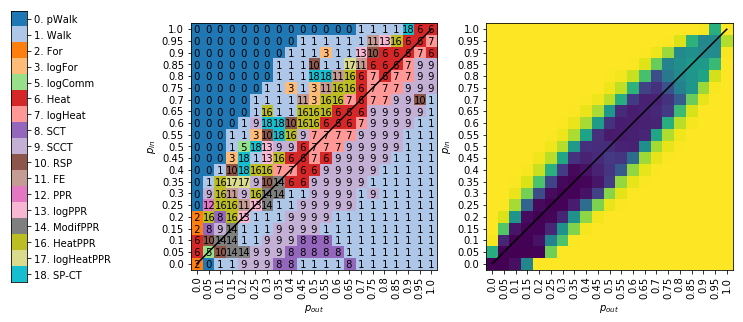

In [228]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(colorsf[:, None, :])
ax[0].set_yticks(range(len(kernelsf)))
ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].yaxis.tick_right()
ax[0].set_yticklabels([f'{i}. {x}' for i, x in zip(colorsidxf, kernelsf)]);

ax[1].imshow(best_measure_color[::-1])
ax[1].set_yticks(range(len(p_ins)))
ax[1].set_xticks(range(len(p_outs)))
ax[1].set_yticklabels(p_ins[::-1])
ax[1].set_xticklabels(p_outs, rotation=90)
ax[1].set_ylabel('$p_{in}$')
ax[1].set_xlabel('$p_{out}$')
ax[1].plot(range(21)[::-1], range(21), color='black')

for i in range(21):
    for j in range(21):
        if not np.isnan(best_measure[i][j]):
            ax[1].text(j-0.5, 21-i-0.65, str(int(best_measure[i][j])).rjust(2))

ax[2].imshow(best_ari[::-1], vmin=0, vmax=1)
ax[2].set_yticks(range(len(p_ins)))
ax[2].set_xticks(range(len(p_outs)))
ax[2].set_yticklabels(p_ins[::-1])
ax[2].set_xticklabels(p_outs, rotation=90)
ax[2].set_ylabel('$p_{in}$')
ax[2].set_xlabel('$p_{out}$')
ax[2].plot(range(21)[::-1], range(21), color='black')

In [229]:
sorted(global_ratings.items(), key=lambda x: x[1], reverse=True)

[('RSP', 6312),
 ('SCCT', 6205),
 ('logPPR', 5974),
 ('logModifPPR', 5906),
 ('Walk', 5843),
 ('SCT', 5817),
 ('SP-CT', 5811),
 ('FE', 5777),
 ('logHeat', 5471),
 ('logHeatPPR', 5171),
 ('Heat', 4543),
 ('HeatPPR', 4535),
 ('logFor', 4354),
 ('logComm', 4137),
 ('PPR', 3400),
 ('Comm', 3245),
 ('ModifPPR', 3017),
 ('pWalk', 2776),
 ('For', 2030)]

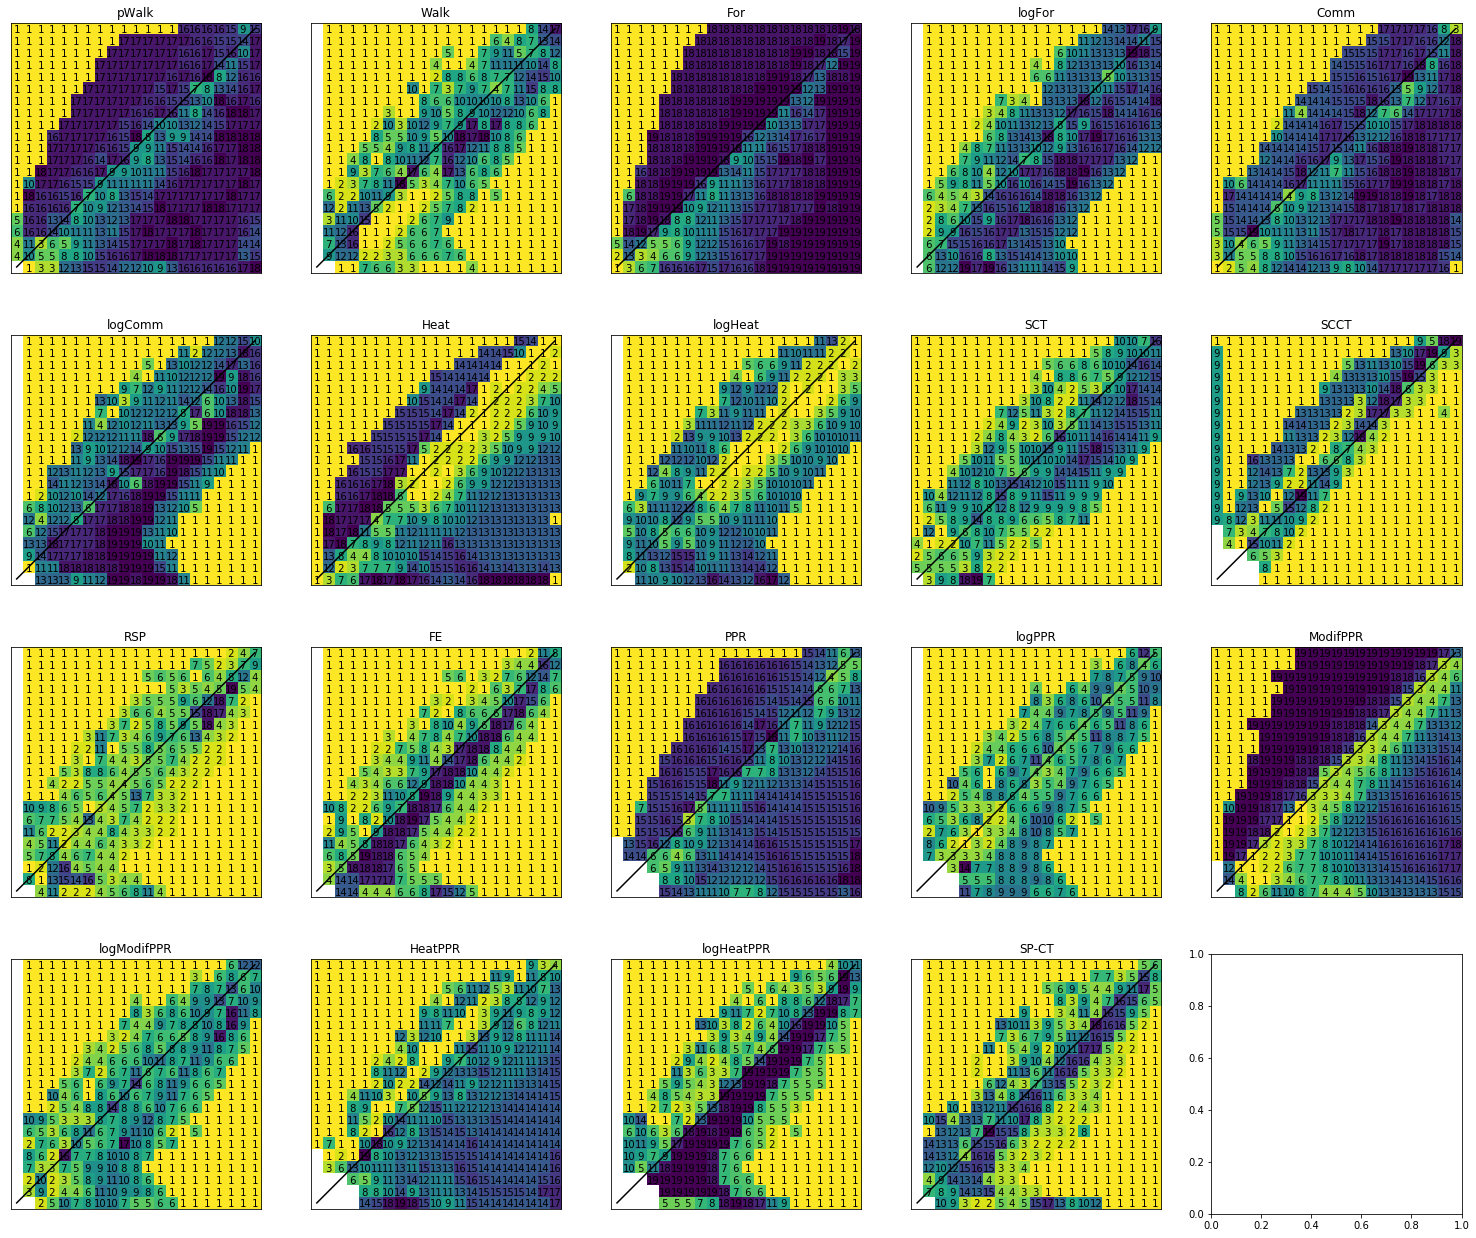

In [216]:
fig, ax = plt.subplots(4, 5, figsize=(26, 22))

for measure_name, measure_idx in kernel_ids.items():
    axi = ax[measure_idx // 5][measure_idx % 5]
    axi.imshow(measure_ratings[::-1, :, measure_idx], cmap='viridis_r')

    axi.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    axi.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
    
    axi.set_title(measure_name)
    
    axi.plot(range(21)[::-1], range(21), color='black')
    
    for i in range(21):
        for j in range(21):
            a = measure_ratings[:, :, measure_idx][i, j]
            if not np.isnan(a):
                text = str(int(a))
                axi.text(j-0.5, 21-i-0.65, text.rjust(2))